# Building Footprint Data Processing Notebook

## Overview

This Jupyter Notebook demonstrates the step-by-step process of generating output products using the available building footprint data stored in a KML file. The workflow involves extracting relevant spatial information from the KML file and integrating it with both training and validation data.
- Load and parse the building footprint data from the provided KML file.
- Process and extract necessary spatial features from the building footprint data.
- Utilize the extracted data to generate meaningful output products.
- Apply the processed building footprint data to both training and validation datasets.

## Data Sources

### 1. Building Footprint Data (KML Format)  
- This file contains geographic information representing building structures within a specific area.  
- The data will be parsed to extract relevant details such as building locations and other spatial attributes.

### 2. Training Dataset  
- We have curated data for the **New York region**.  
- The dataset consists of **geo-locations** (Longitude and Latitude), along with additional fields including **date & time** of data collection and the **Urban Heat Island (UHI) index** for each location.  
- This data will be used to **train the model** for UHI index prediction.

## Validation Dataset

- The validation dataset consists of a **set of test coordinates** provided in the **"Submission_template.csv"** file.  
- Unlike the training dataset, this file **does not contain the UHI index**, as it is the **target variable to be predicted**.  
- The trained model will be used to predict the **UHI index** for these test coordinates based on the extracted spatial features and other relevant informatioluation.


In [1]:
# Loading required libraries
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore')

In [2]:
# Define file path
kml_file = "Building_Footprint.kml"

try:
    # Load the KML file
    building_gdf = gpd.read_file(kml_file, driver="KML")
    
    # Display basic information
    print("Building Footprint Data Loaded Successfully")
    print(building_gdf.info())

except Exception as e:
    print(f"Error loading KML file: {e}")


Building Footprint Data Loaded Successfully
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9436 entries, 0 to 9435
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         9436 non-null   object  
 1   Description  9436 non-null   object  
 2   geometry     9436 non-null   geometry
dtypes: geometry(1), object(2)
memory usage: 221.3+ KB
None


In [3]:
# Load training data
training_data = pd.read_csv("Training_data.csv")
print(training_data.head())

# Load validation data
validation_data = pd.read_csv("Submission_template.csv")
print(validation_data.head())

   Longitude   Latitude          datetime  UHI Index
0 -73.909167  40.813107  24-07-2021 15:53   1.030289
1 -73.909187  40.813045  24-07-2021 15:53   1.030289
2 -73.909215  40.812978  24-07-2021 15:53   1.023798
3 -73.909242  40.812908  24-07-2021 15:53   1.023798
4 -73.909257  40.812845  24-07-2021 15:53   1.021634
   Longitude   Latitude  UHI Index
0 -73.971665  40.788763        NaN
1 -73.971928  40.788875        NaN
2 -73.967080  40.789080        NaN
3 -73.972550  40.789082        NaN
4 -73.969697  40.787953        NaN


In [4]:
# Convert Training Data to GeoDataFrame
training_data["geometry"] = gpd.points_from_xy(training_data["Longitude"], training_data["Latitude"])
training_gdf = gpd.GeoDataFrame(training_data, geometry="geometry", crs="EPSG:4326")

# Convert Validation Data to GeoDataFrame
validation_data["geometry"] = gpd.points_from_xy(validation_data["Longitude"], validation_data["Latitude"])
validation_gdf = gpd.GeoDataFrame(validation_data, geometry="geometry", crs="EPSG:4326")

# Ensure Building Footprint Data is in EPSG:4326
if building_gdf.crs != "EPSG:4326":
    building_gdf = building_gdf.to_crs("EPSG:4326")

# Spatial Join: Assign building attributes to training data
training_with_building = gpd.sjoin(training_gdf, building_gdf, how="left", predicate="within")

# Spatial Join: Assign building attributes to validation data
validation_with_building = gpd.sjoin(validation_gdf, building_gdf, how="left", predicate="within")

# Display results
print("Training Data with Building Attributes:")
print(training_with_building.head(), "\n")

print("Validation Data with Building Attributes:")
print(validation_with_building.head())


Training Data with Building Attributes:
   Longitude   Latitude          datetime  UHI Index  \
0 -73.909167  40.813107  24-07-2021 15:53   1.030289   
1 -73.909187  40.813045  24-07-2021 15:53   1.030289   
2 -73.909215  40.812978  24-07-2021 15:53   1.023798   
3 -73.909242  40.812908  24-07-2021 15:53   1.023798   
4 -73.909257  40.812845  24-07-2021 15:53   1.021634   

                     geometry  index_right Name Description  
0  POINT (-73.90917 40.81311)          NaN  NaN         NaN  
1  POINT (-73.90919 40.81304)          NaN  NaN         NaN  
2  POINT (-73.90922 40.81298)          NaN  NaN         NaN  
3  POINT (-73.90924 40.81291)          NaN  NaN         NaN  
4  POINT (-73.90926 40.81284)          NaN  NaN         NaN   

Validation Data with Building Attributes:
   Longitude   Latitude  UHI Index                    geometry  index_right  \
0 -73.971665  40.788763        NaN  POINT (-73.97166 40.78876)          NaN   
1 -73.971928  40.788875        NaN  POINT (-73.97

### for Training Data

In [5]:
# Load and Convert Training Data to GeoDataFrame
training_data["geometry"] = gpd.points_from_xy(training_data["Longitude"], training_data["Latitude"])
training_gdf = gpd.GeoDataFrame(training_data, geometry="geometry", crs="EPSG:4326")

# Reproject to a metric CRS
training_gdf = training_gdf.to_crs("EPSG:32618")

# Load and Process Building Footprint Data
if building_gdf.crs != "EPSG:4326":
    building_gdf = building_gdf.to_crs("EPSG:4326")
building_gdf = building_gdf.to_crs("EPSG:32618")

# Calculate building area in square meters
building_gdf["building_area"] = building_gdf.geometry.area

# Define buffer distances in meters
buffer_distances = [100, 500, 1000]

# Initialize result columns in training_gdf
for dist in buffer_distances:
    training_gdf[f"building_count_{dist}m"] = 0
    training_gdf[f"total_building_area_{dist}m"] = 0.0

# Perform Spatial Analysis for Training Data ---
for dist in buffer_distances:
    training_buffers = training_gdf.copy()
    training_buffers["buffer"] = training_buffers.geometry.buffer(dist)  # Buffer in meters
    training_buffers = training_buffers.set_geometry("buffer")

    # Spatial join with building footprints
    join_df = gpd.sjoin(building_gdf, training_buffers, how="inner", predicate="intersects")

    # Aggregate statistics
    stats = join_df.groupby("index_right").agg(
        building_count=("building_area", "count"),
        total_building_area=("building_area", "sum")
    )

    # Update training_gdf with computed stats
    for idx, row in stats.iterrows():
        training_gdf.loc[idx, f"building_count_{dist}m"] = row["building_count"]
        training_gdf.loc[idx, f"total_building_area_{dist}m"] = row["total_building_area"]

# Display results
print(training_gdf[["Longitude", "Latitude", "building_count_100m", "total_building_area_100m",
                    "building_count_500m", "total_building_area_500m",
                    "building_count_1000m", "total_building_area_1000m"]].head())


   Longitude   Latitude  building_count_100m  total_building_area_100m  \
0 -73.909167  40.813107                    9              22021.913865   
1 -73.909187  40.813045                   10              23529.583653   
2 -73.909215  40.812978                    9              21067.543693   
3 -73.909242  40.812908                    8              19166.747335   
4 -73.909257  40.812845                    8              19166.747335   

   building_count_500m  total_building_area_500m  building_count_1000m  \
0                  173             238056.221827                   722   
1                  174             242292.709280                   720   
2                  177             247121.188061                   718   
3                  175             246855.836543                   716   
4                  173             245431.994656                   709   

   total_building_area_1000m  
0              990085.767678  
1              994295.954553  
2              99

In [6]:
# Display the data
training_gdf.head()

,Longitude,Latitude,datetime,UHI Index,geometry,building_count_100m,total_building_area_100m,building_count_500m,total_building_area_500m,building_count_1000m,total_building_area_1000m
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,POINT (592000.223 4518582.908),9,22021.913865,173,238056.221827,722,990085.767678
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,POINT (591998.621 4518576.041),10,23529.583653,174,242292.709280,720,994295.954553
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,POINT (591996.324 4518568.61),9,21067.543693,177,247121.188061,718,990577.919305
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,POINT (591994.171 4518560.812),8,19166.747335,175,246855.836543,716,990771.620217
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,POINT (591992.993 4518553.766),8,19166.747335,173,245431.994656,709,985447.972126


In [7]:
training_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Longitude                  11229 non-null  float64 
 1   Latitude                   11229 non-null  float64 
 2   datetime                   11229 non-null  object  
 3   UHI Index                  11229 non-null  float64 
 4   geometry                   11229 non-null  geometry
 5   building_count_100m        11229 non-null  int64   
 6   total_building_area_100m   11229 non-null  float64 
 7   building_count_500m        11229 non-null  int64   
 8   total_building_area_500m   11229 non-null  float64 
 9   building_count_1000m       11229 non-null  int64   
 10  total_building_area_1000m  11229 non-null  float64 
dtypes: float64(6), geometry(1), int64(3), object(1)
memory usage: 965.1+ KB


In [8]:
training_gdf.describe()

,Longitude,Latitude,UHI Index,building_count_100m,total_building_area_100m,building_count_500m,total_building_area_500m,building_count_1000m,total_building_area_1000m
count,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,1.122900e+04
mean,-73.933927,40.808800,1.000001,7.802743,25306.011310,118.525514,284410.477453,433.005700,9.535281e+05
std,0.028253,0.023171,0.016238,5.042782,17140.480915,57.906174,107987.302328,205.426095,2.546515e+05
min,-73.994457,40.758792,0.956122,0.000000,0.000000,13.000000,36932.345822,137.000000,3.793870e+05
25%,-73.955703,40.790905,0.988577,5.000000,14025.640589,75.000000,203937.328520,251.000000,7.763063e+05
50%,-73.932968,40.810688,1.000237,7.000000,22547.244205,109.000000,275895.497605,375.000000,9.100941e+05
75%,-73.909647,40.824515,1.011176,10.000000,33998.862853,152.000000,337583.827525,629.000000,1.061724e+06
max,-73.879458,40.859497,1.046036,32.000000,101456.900911,316.000000,638785.758359,942.000000,1.789912e+06


### for Validation Data

In [9]:
# Load and Convert Validation Data to GeoDataFrame
validation_data["geometry"] = gpd.points_from_xy(validation_data["Longitude"], validation_data["Latitude"])
validation_gdf = gpd.GeoDataFrame(validation_data, geometry="geometry", crs="EPSG:4326")

# Reproject to metric CRS
validation_gdf = validation_gdf.to_crs("EPSG:32618")

# Load and Process Building Footprint Data
if building_gdf.crs != "EPSG:4326":
    building_gdf = building_gdf.to_crs("EPSG:4326")
building_gdf = building_gdf.to_crs("EPSG:32618")

# Calculate building area in square meters
building_gdf["building_area"] = building_gdf.geometry.area

# Define buffer distances in meters
buffer_distances = [100, 500, 1000]

# Initialize result columns in validation_gdf
for dist in buffer_distances:
    validation_gdf[f"building_count_{dist}m"] = 0
    validation_gdf[f"total_building_area_{dist}m"] = 0.0

# Perform Spatial Analysis for Validation Data
for dist in buffer_distances:
    validation_buffers = validation_gdf.copy()
    validation_buffers["buffer"] = validation_buffers.geometry.buffer(dist)  # Buffer in meters
    validation_buffers = validation_buffers.set_geometry("buffer")

    # Spatial join with building footprints
    join_df = gpd.sjoin(building_gdf, validation_buffers, how="inner", predicate="intersects")

    # Aggregate statistics
    stats = join_df.groupby("index_right").agg(
        building_count=("building_area", "count"),
        total_building_area=("building_area", "sum")
    )

    # Update validation_gdf with computed stats
    for idx, row in stats.iterrows():
        validation_gdf.loc[idx, f"building_count_{dist}m"] = row["building_count"]
        validation_gdf.loc[idx, f"total_building_area_{dist}m"] = row["total_building_area"]

# Display results
print(validation_gdf[["Longitude", "Latitude", "building_count_100m", "total_building_area_100m",
                      "building_count_500m", "total_building_area_500m",
                      "building_count_1000m", "total_building_area_1000m"]].head())


   Longitude   Latitude  building_count_100m  total_building_area_100m  \
0 -73.971665  40.788763                   10              30704.263610   
1 -73.971928  40.788875                    9              24891.711996   
2 -73.967080  40.789080                    3              32298.190406   
3 -73.972550  40.789082                    8              23026.854977   
4 -73.969697  40.787953                    5              53357.162819   

   building_count_500m  total_building_area_500m  building_count_1000m  \
0                   94             434537.078135                   235   
1                  101             469133.965195                   237   
2                   61             265037.151345                   241   
3                  105             488182.982636                   237   
4                   66             331546.180958                   228   

   total_building_area_1000m  
0              956067.936204  
1              967377.849328  
2              98

In [10]:
# Display the data
validation_gdf.head()

,Longitude,Latitude,UHI Index,geometry,building_count_100m,total_building_area_100m,building_count_500m,total_building_area_500m,building_count_1000m,total_building_area_1000m
0,-73.971665,40.788763,NaN,POINT (586760.76 4515816.875),10,30704.263610,94,434537.078135,235,956067.936204
1,-73.971928,40.788875,NaN,POINT (586738.398 4515829.011),9,24891.711996,101,469133.965195,237,967377.849328
2,-73.967080,40.789080,NaN,POINT (587147.19 4515856.574),3,32298.190406,61,265037.151345,241,981122.105508
3,-73.972550,40.789082,NaN,POINT (586685.678 4515851.338),8,23026.854977,105,488182.982636,237,986609.310192
4,-73.969697,40.787953,NaN,POINT (586927.888 4515728.908),5,53357.162819,66,331546.180958,228,976210.864820


In [11]:
validation_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Longitude                  1040 non-null   float64 
 1   Latitude                   1040 non-null   float64 
 2   UHI Index                  0 non-null      float64 
 3   geometry                   1040 non-null   geometry
 4   building_count_100m        1040 non-null   int64   
 5   total_building_area_100m   1040 non-null   float64 
 6   building_count_500m        1040 non-null   int64   
 7   total_building_area_500m   1040 non-null   float64 
 8   building_count_1000m       1040 non-null   int64   
 9   total_building_area_1000m  1040 non-null   float64 
dtypes: float64(6), geometry(1), int64(3)
memory usage: 81.4 KB


In [12]:
validation_gdf.describe()

,Longitude,Latitude,UHI Index,building_count_100m,total_building_area_100m,building_count_500m,total_building_area_500m,building_count_1000m,total_building_area_1000m
count,1040.000000,1040.000000,0.0,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1.040000e+03
mean,-73.934816,40.807991,NaN,7.820192,25944.350847,118.625000,291150.227774,428.366346,9.588085e+05
std,0.028661,0.023200,NaN,4.903631,17256.746952,57.128427,109954.008088,203.542849,2.605459e+05
min,-73.993163,40.758877,NaN,0.000000,0.000000,17.000000,46342.998064,138.000000,4.186840e+05
25%,-73.957030,40.790802,NaN,5.000000,14381.210434,74.750000,208583.484743,247.750000,7.801669e+05
50%,-73.934618,40.809553,NaN,7.000000,23253.719660,108.000000,279316.140814,369.500000,9.125263e+05
75%,-73.910655,40.823054,NaN,10.000000,35336.443034,155.000000,348968.118875,607.000000,1.061079e+06
max,-73.879537,40.859243,NaN,30.000000,99695.379486,311.000000,637003.033869,914.000000,1.752368e+06


#### Visualization for Training Data

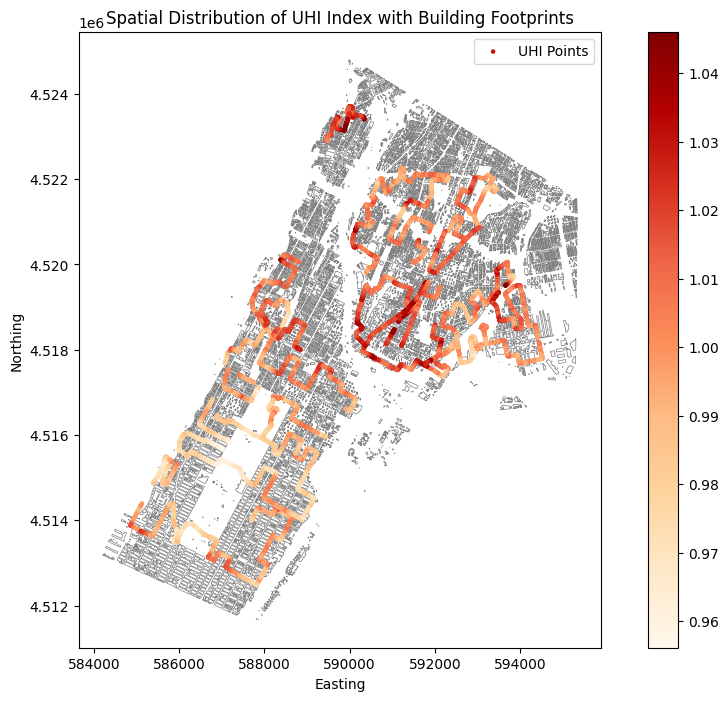

In [13]:
# Spatial Distribution of training data
fig, ax = plt.subplots(figsize=(12, 8))

# Plot building footprints
building_gdf.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.5, label="Buildings")

# Plot UHI points (from training_gdf, colored by UHI Index)
training_gdf.plot(column="UHI Index", cmap="OrRd", markersize=5, legend=True, ax=ax, label="UHI Points")

ax.set_title("Spatial Distribution of UHI Index with Building Footprints")
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.legend()

plt.show()

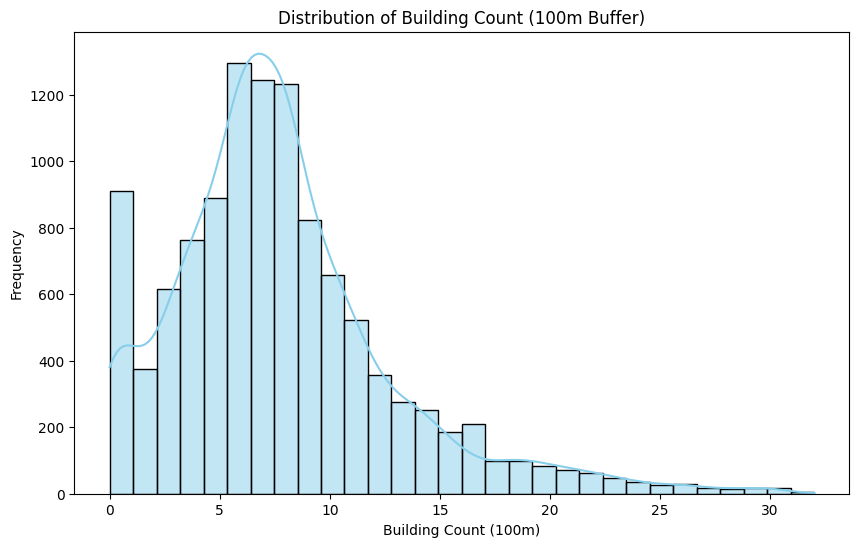

In [14]:
# Histogram for Building Count within 100m Buffer
plt.figure(figsize=(10, 6))
sns.histplot(training_gdf["building_count_100m"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Building Count (100m Buffer)")
plt.xlabel("Building Count (100m)")
plt.ylabel("Frequency")
plt.show()



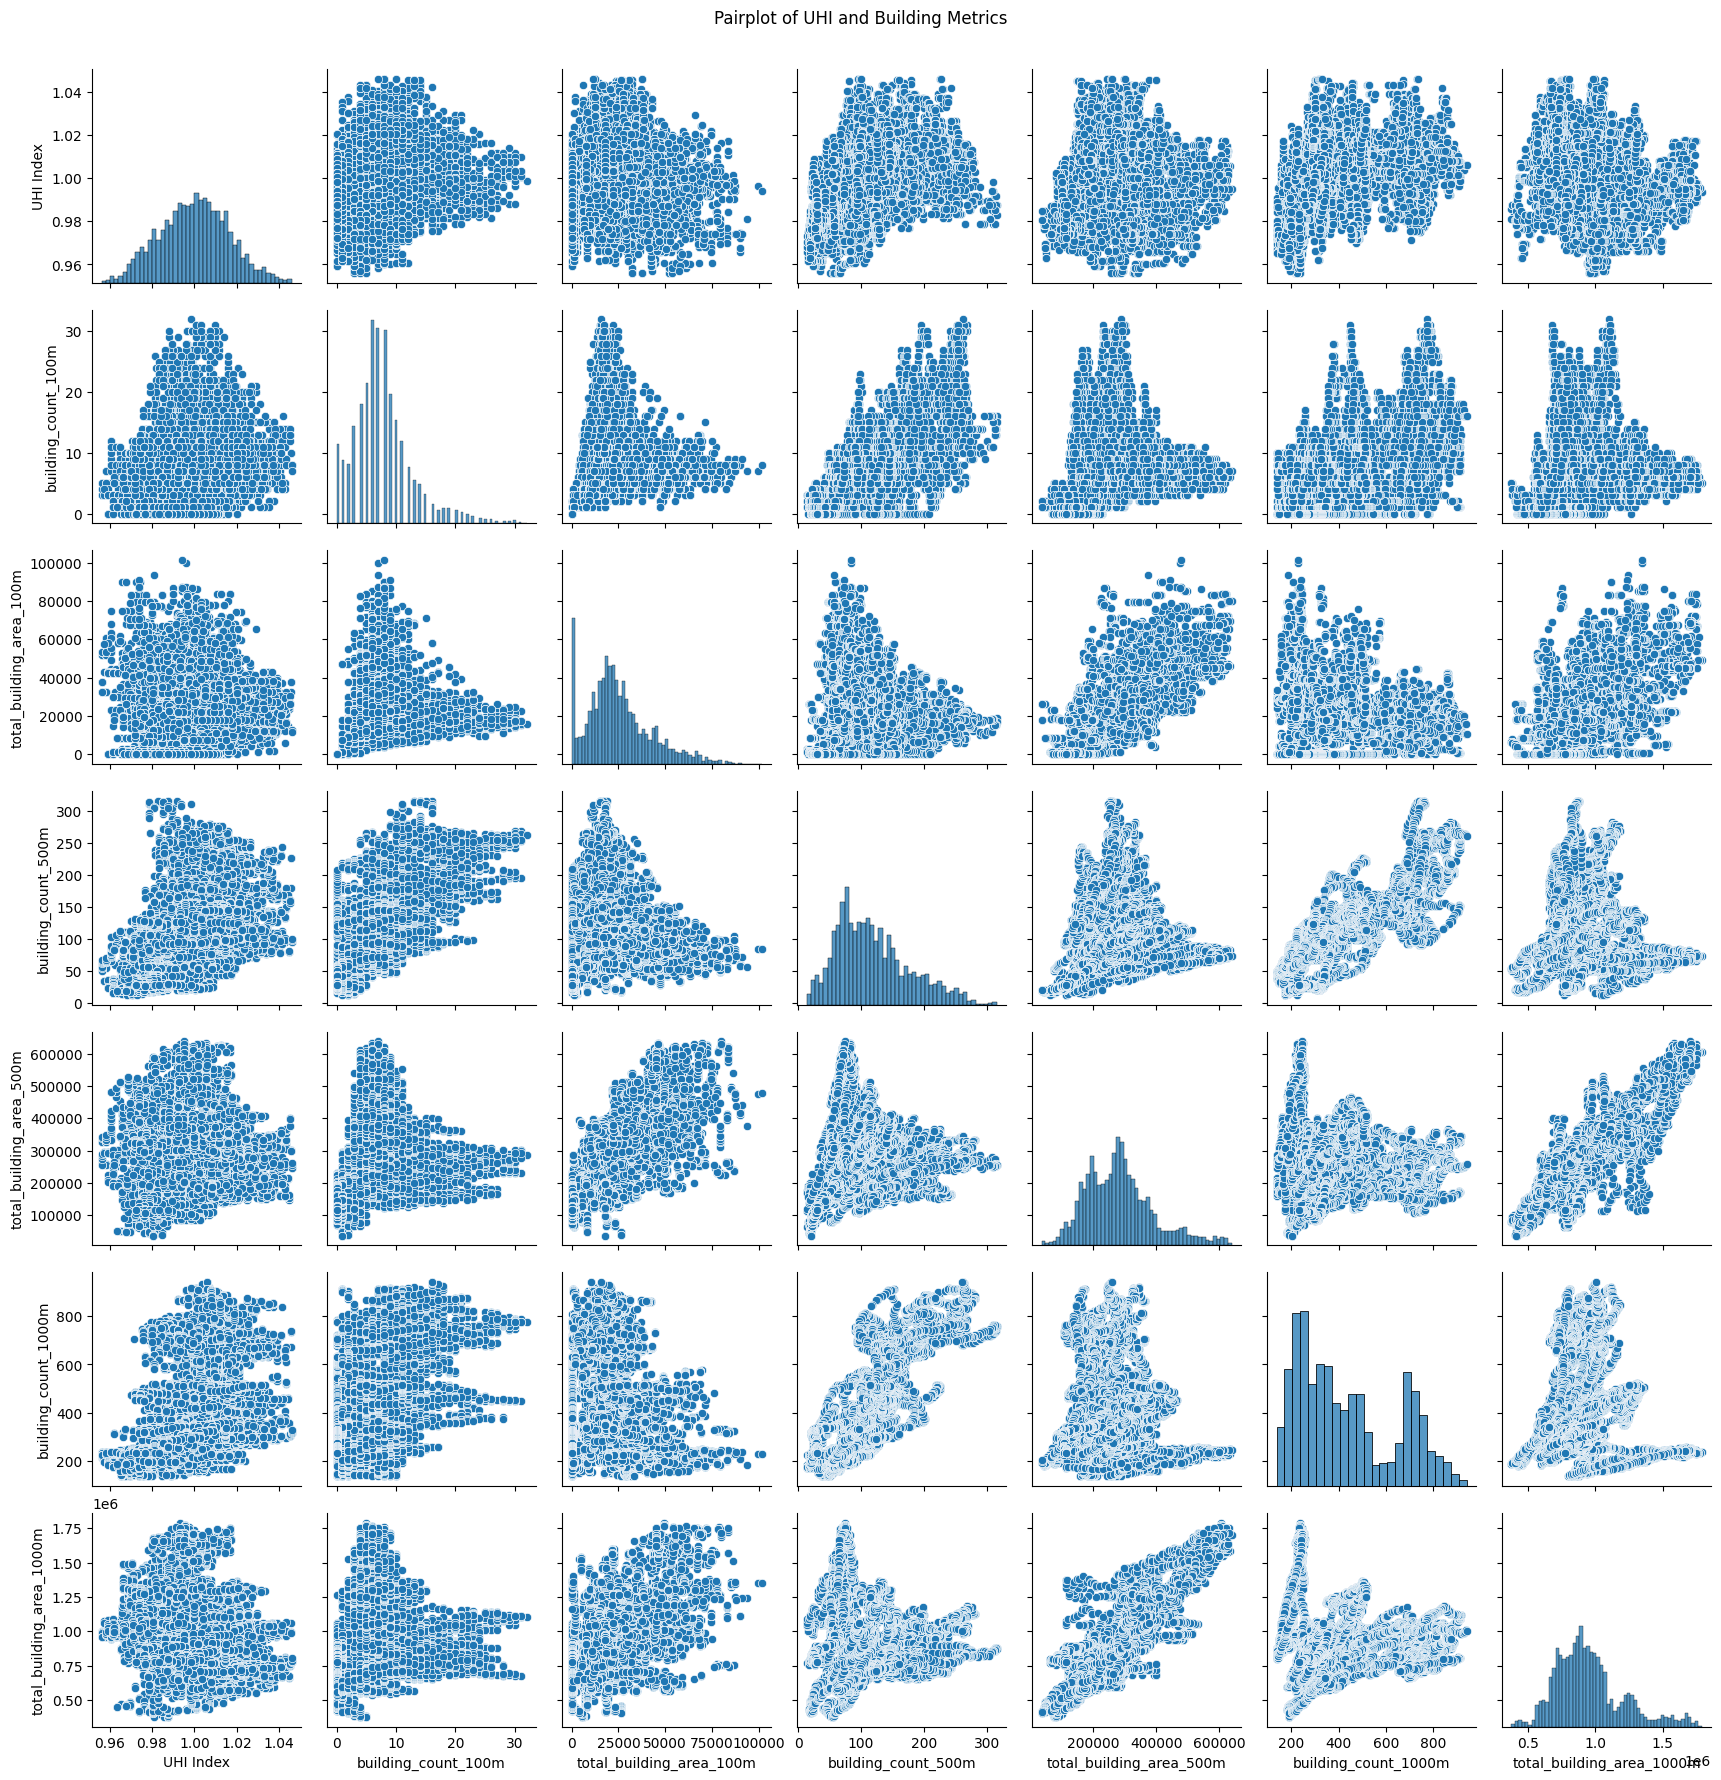

In [15]:
# 4. Pairplot to explore relationships among multiple variables
selected_cols = [
    "UHI Index",
    "building_count_100m",
    "total_building_area_100m",
    "building_count_500m",
    "total_building_area_500m",
    "building_count_1000m",
    "total_building_area_1000m"
]
sns.pairplot(training_gdf[selected_cols])
plt.suptitle("Pairplot of UHI and Building Metrics", y=1.02)
plt.show()


#### Visualization for Validation Data

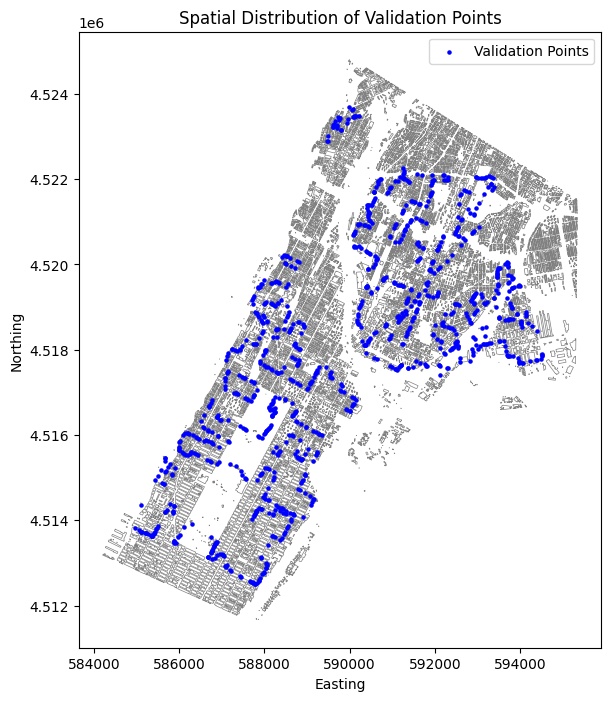

In [16]:
# Spatial Distribution of validation data
fig, ax = plt.subplots(figsize=(12, 8))

# Plot building footprints (assumed to be polygons)
building_gdf.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.5, label="Buildings")

# Plot validation points, colored by UHI Index if available
if validation_gdf["UHI Index"].notnull().sum() > 0:
    validation_gdf.plot(column="UHI Index", cmap="OrRd", markersize=5, legend=True, ax=ax, label="Validation Points")
    ax.set_title("Spatial Distribution of UHI Index - Validation Data")
else:
    validation_gdf.plot(markersize=5, color="blue", ax=ax, label="Validation Points")
    ax.set_title("Spatial Distribution of Validation Points")

ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.legend()

plt.show()

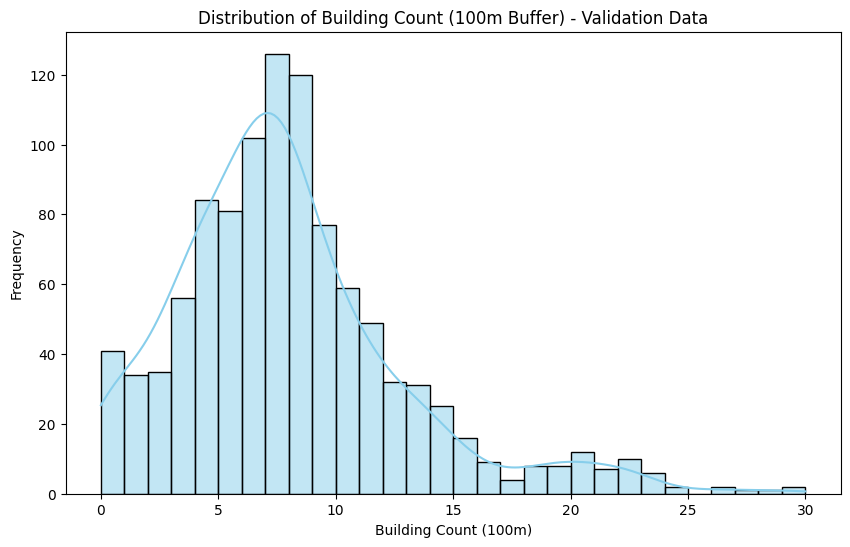

In [17]:
# Histogram for Building Count within 100m Buffer
plt.figure(figsize=(10, 6))
sns.histplot(validation_gdf["building_count_100m"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Building Count (100m Buffer) - Validation Data")
plt.xlabel("Building Count (100m)")
plt.ylabel("Frequency")
plt.show()



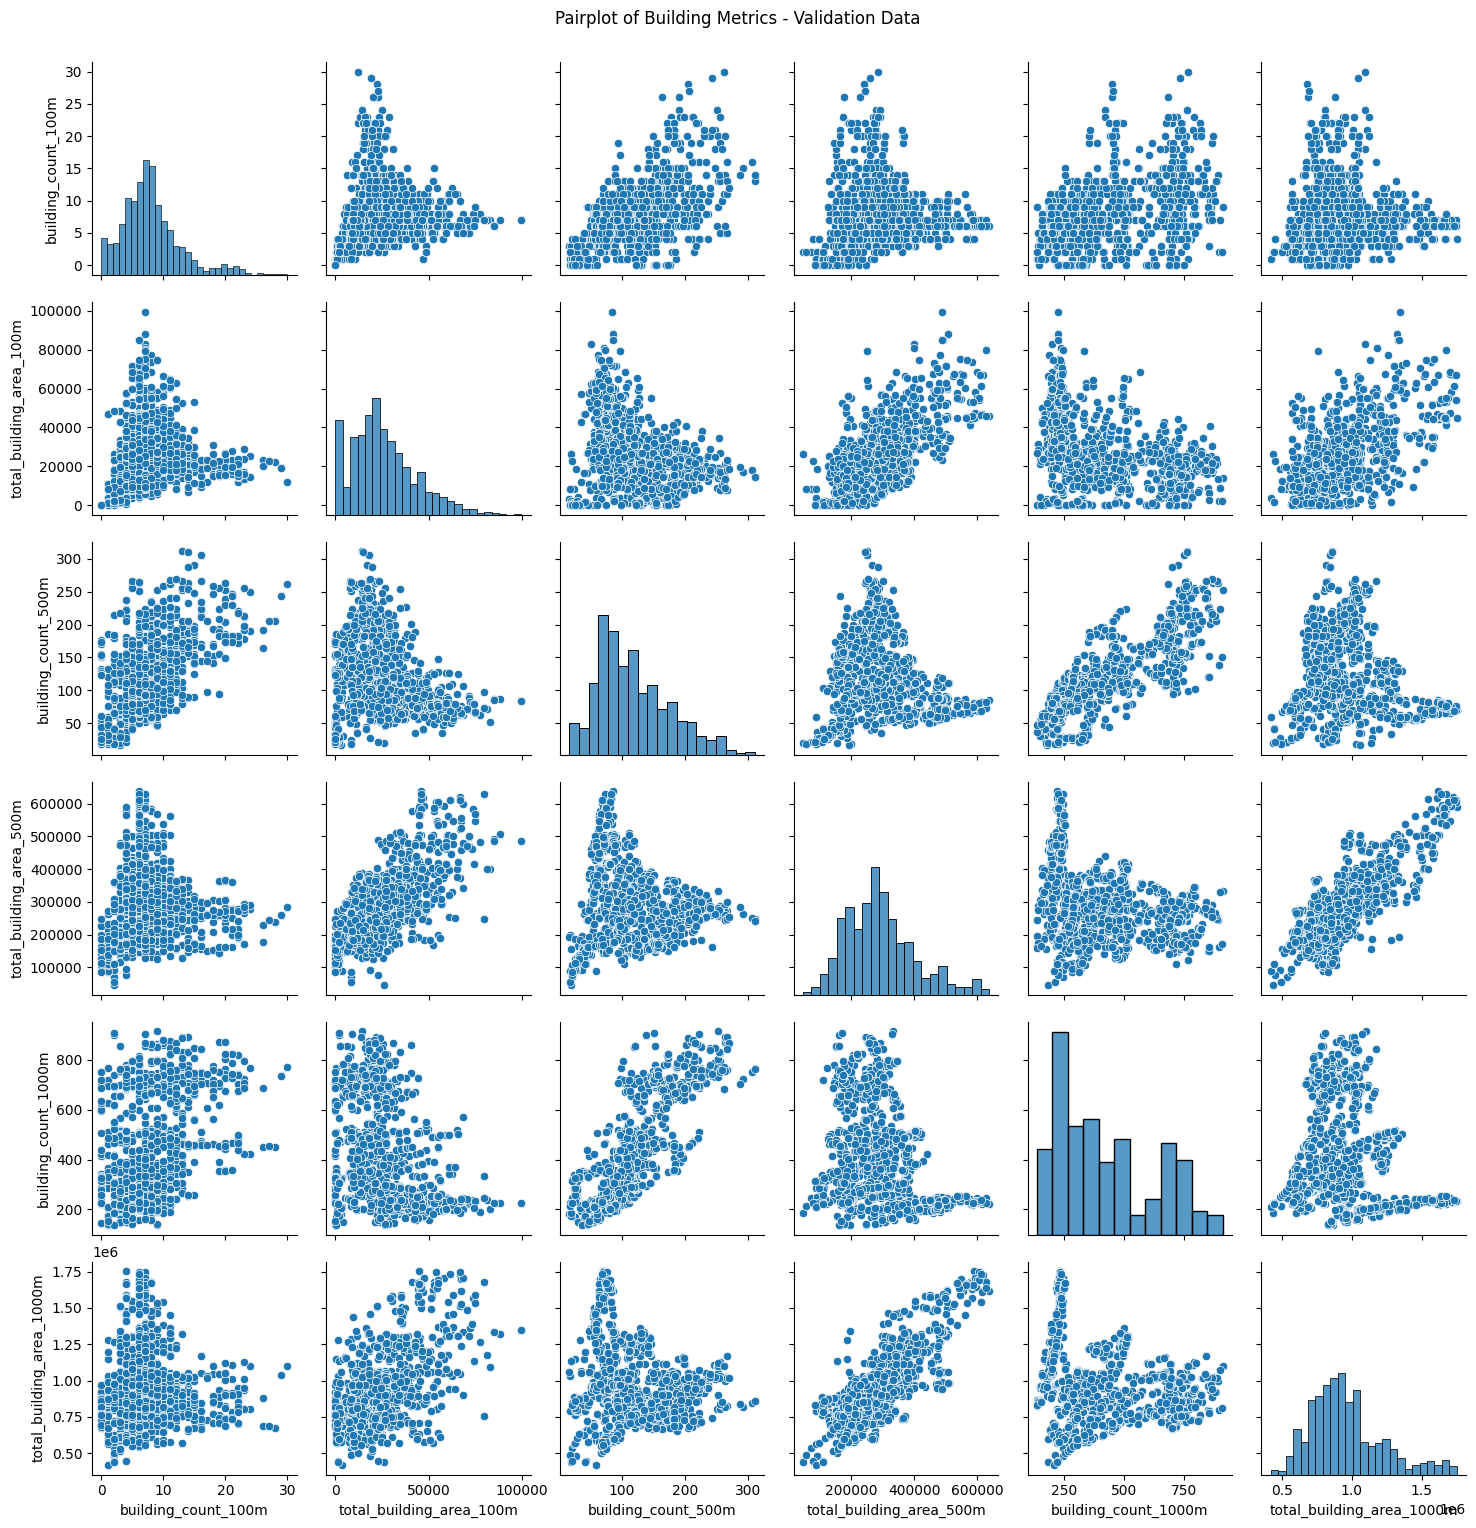

In [18]:
# Pairplot to Explore Relationships Among Building Metrics
selected_cols = [
    "UHI Index",
    "building_count_100m",
    "total_building_area_100m",
    "building_count_500m",
    "total_building_area_500m",
    "building_count_1000m",
    "total_building_area_1000m"
]
# Remove "UHI Index" if it's entirely missing
if validation_gdf["UHI Index"].isnull().all():
    selected_cols.remove("UHI Index")

sns.pairplot(validation_gdf[selected_cols])
plt.suptitle("Pairplot of Building Metrics - Validation Data", y=1.02)
plt.show()


#### Save the resulting DataFrame to a CSV file

In [19]:
# Save training GeoDataFrame to CSV
training_gdf.to_csv("training_building_output.csv", index=False)

# Save validation GeoDataFrame to CSV
validation_gdf.to_csv("validation_building_output.csv", index=False)
